# 540 Project - Vols

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Volatility Feature Definitions

- Realized Variance (RV):
A non-parametric estimate of total daily volatility, computed from high-frequency intraday returns. It captures the overall magnitude of price fluctuations.

- Bipower Variation (BPV):
A robust estimator of the continuous diffusion component of volatility. It removes the effect of jumps and reflects “normal” market volatility.

- Good Variance:
The part of realized variance coming from positive intraday price movements. Often interpreted as volatility associated with upward market moves.

- Bad Variance:
The part of realized variance driven by negative price movements. Commonly linked to downside risk, fear, and bad news.

- Realized Quarticity (RQ):
A higher-order moment of high-frequency returns that measures the variability of volatility itself. Often used to scale standard errors or construct jump tests.

## Processing Dataframe

### Reading Original Sheets

In [2]:
# Define the file path
file_path = 'data/RV_March2024.xlsx'

# Read the index (Dates) and column names (Companies) sheets
dates = pd.read_excel(file_path, sheet_name='Dates', header=None)[0].values  # Assuming one column for dates
companies = pd.read_excel(file_path, sheet_name='Companies', header=None)[0].values  # Read the first row as header

In [1]:
def read_sheet(name, file_path):
    df = pd.read_excel(file_path, sheet_name=name, header=None)
    df.index = dates
    df.columns = companies
    return df

# Read sheets
rv    = read_sheet("RV", file_path)
rv_5  = read_sheet("RV_5", file_path)
bpv   = read_sheet("BPV", file_path)
bpv_5 = read_sheet("BPV_5", file_path)
good  = read_sheet("Good", file_path)
good_5= read_sheet("Good_5", file_path)
bad   = read_sheet("Bad", file_path)
bad_5 = read_sheet("Bad_5", file_path)
rq    = read_sheet("RQ", file_path)
rq_5  = read_sheet("RQ_5", file_path)

NameError: name 'file_path' is not defined

### Convert to Long Format

In [4]:
# Convert to long format
def to_long(df, value_name):
    return (df
            .reset_index()
            .melt(id_vars="index", var_name="ticker", value_name=value_name)
            .rename(columns={"index": "date"}))

rv_long    = to_long(rv, "RV")
rv5_long   = to_long(rv_5, "RV_5")
bpv_long   = to_long(bpv, "BPV")
bpv5_long  = to_long(bpv_5, "BPV_5")
good_long  = to_long(good, "Good")
good5_long = to_long(good_5, "Good_5")
bad_long   = to_long(bad, "Bad")
bad5_long  = to_long(bad_5, "Bad_5")
rq_long    = to_long(rq, "RQ")
rq5_long   = to_long(rq_5, "RQ_5")

In [5]:
# 6. Merge all long tables on (date, ticker)
df = rv_long
df = df.merge(bpv_long,  on=["date", "ticker"])
df = df.merge(good_long, on=["date", "ticker"])
df = df.merge(bad_long,  on=["date", "ticker"])
df = df.merge(rq_long,   on=["date", "ticker"])
df = df.merge(rv5_long,  on=["date", "ticker"])
df = df.merge(bpv5_long, on=["date", "ticker"])
df = df.merge(good5_long,on=["date", "ticker"])
df = df.merge(bad5_long, on=["date", "ticker"])
df = df.merge(rq5_long,  on=["date", "ticker"])

df.head()

,date,ticker,RV,BPV,Good,Bad,RQ,RV_5,BPV_5,Good_5,Bad_5,RQ_5
0,02-Jan-2003,AAPL,8.308199,6.201846,5.482017,2.826182,263.025222,6.493909,3.771960,5.102315,1.391595,152.729402
1,03-Jan-2003,AAPL,6.568160,5.331377,3.363345,3.204814,98.476434,6.574494,5.893317,3.638035,2.936459,62.054316
2,06-Jan-2003,AAPL,7.344418,6.179154,3.854715,3.489703,301.882895,5.992264,4.443162,3.879084,2.113180,180.213258
3,07-Jan-2003,AAPL,10.013332,9.130347,5.541810,4.471522,215.268172,9.500654,7.120007,5.782715,3.717939,197.381861
4,08-Jan-2003,AAPL,6.098212,4.921065,3.248214,2.849998,97.966971,4.940525,5.433291,2.473166,2.467359,35.726435


In [6]:
df.shape

(160380, 12)

### Missing-Data Analysis: Zero-Value Periods and First Valid Dates

However, some missing values are recorded as zeros. We would like to determine the missing-data percentage for each company and identify the date from which valid data becomes available.

In [7]:
features = ["RV", "BPV", "Good", "Bad", "RQ", "RV_5", "BPV_5", "Good_5", "Bad_5", "RQ_5"]

df["all_zero"] = (df[features].sum(axis=1) == 0)

# Find the first valid date for each company
start_dates = (
    df[~df["all_zero"]]
    .groupby("ticker")["date"]
    .min()
    .reset_index()
    .rename(columns={"date": "first_valid_date"})
)

# Ensure datetime format
df["date"] = pd.to_datetime(df["date"])
start_dates["first_valid_date"] = pd.to_datetime(start_dates["first_valid_date"])

# Check missing values after the first valid date for each ticker
results = []

for _, row in start_dates.iterrows():
    t = row["ticker"]
    fd = row["first_valid_date"]
    
    sub = df[(df["ticker"] == t) & (df["date"] >= fd)]
    after_missing = sub["all_zero"].sum()
    
    results.append({
        "ticker": t,
        "first_valid_date": fd.date(),
        "missing_after_start": int(after_missing)
    })

results_df = pd.DataFrame(results)
results_df

,ticker,first_valid_date,missing_after_start
0,AAPL,2003-04-01,0
1,AMGN,2003-04-01,0
2,AMZN,2003-04-01,0
3,AXP,2003-04-01,0
4,BA,2003-04-01,0
5,CAT,2003-04-01,0
6,CRM,2005-04-01,0
7,CSCO,2003-04-01,0
8,CVX,2003-04-01,0
9,DIS,2003-04-01,0


All missing-data instances (all-zero rows) occur only before the first valid date of each ticker. After the first valid date, every company has a fully valid and complete time series.

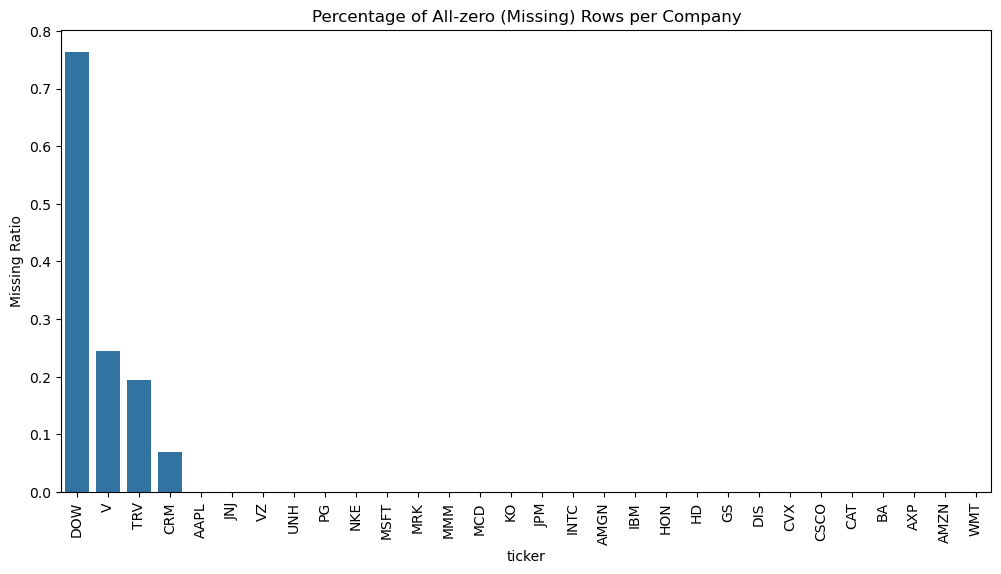

Companies with missing data (zero-recorded values):
DOW: 0.763
V: 0.245
TRV: 0.195
CRM: 0.069


In [8]:
# calculate missing pct
zero_ratio = (df.groupby("ticker")["all_zero"].mean().sort_values(ascending=False))

# plot
plt.figure(figsize=(12,6))
sns.barplot(x=zero_ratio.index, y=zero_ratio.values)
plt.xticks(rotation=90)
plt.title("Percentage of All-zero (Missing) Rows per Company")
plt.ylabel("Missing Ratio")
plt.show()

# print companies with missing values
missing_companies = zero_ratio[zero_ratio > 0]

print("Companies with missing data (zero-recorded values):")
for ticker, ratio in missing_companies.items():
    print(f"{ticker}: {ratio:.3f}")

In [12]:
df_clean = df[df["date"] >= "2019-04-01"].copy()

We focus on the 2019–2024 window because it is the first period where all 30 DJIA companies have complete, non-missing volatility data. This avoids zero-recorded gaps and produces a clean and consistent dataset for EDA. The five-year window is also large enough (≈37k observations) and includes diverse market regimes such as the COVID crash, the rate-hiking cycle, and the recent recovery, providing rich dynamics for volatility analysis.

For modeling, this period allows us to build stable and meaningful machine-learning pipelines using log-transformed features, lagged volatility measures (e.g., RV_lag1, RV_lag5), and jump-related metrics. We plan to construct baseline models—including Linear Regression, Random Forest, and XGBoost—which are well suited for short-memory volatility processes and should perform reliably on this clean subset.

## Exploratory Data Analysis (EDA)

In [13]:
sns.set(style="whitegrid")
features = ["RV", "BPV", "Good", "Bad", "RQ"]

### Summary Statistics

In [14]:
df_clean[features].describe()

,RV,BPV,Good,Bad,RQ
count,37740.000000,37740.000000,37740.000000,37740.000000,3.774000e+04
mean,2.449635,2.316838,1.229991,1.219644,2.645029e+02
std,5.656053,5.205469,2.917187,2.844805,1.353211e+04
min,0.087226,0.072268,0.038783,0.048443,1.990372e-02
25%,0.859341,0.806109,0.421202,0.420934,1.925502e+00
50%,1.382639,1.309991,0.683064,0.687491,5.270518e+00
75%,2.371797,2.256750,1.179179,1.188674,1.607663e+01
max,336.956983,312.806802,152.008985,184.947998,2.234740e+06


In [15]:
skewness = df_clean[features].skew()
kurtosis = df_clean[features].kurt()

print("Skewness:\n", skewness)
print("\nKurtosis:\n", kurtosis)

Skewness:
 RV       16.312037
BPV      15.942165
Good     15.650130
Bad      18.001149
RQ      129.929276
dtype: float64

Kurtosis:
 RV        524.074132
BPV       519.765772
Good      433.200003
Bad       663.599458
RQ      20148.133560
dtype: float64


The volatility measures (RV, BPV, Good, Bad, RQ) exhibit extremely strong right-skewness and heavy-tailed behavior.  
Both skewness and kurtosis values are unusually high, indicating that:

1. Most observations are concentrated near very small values.
2. A small number of extreme volatility spikes stretch the right tail of the distribution.
3. Realized Quarticity (RQ) is especially heavy-tailed, consistent with its sensitivity to jump and tail risk.

This confirms that the volatility features are highly non-normal and dominated by rare but extreme market events (e.g., COVID crash, rate-hike shocks).  
For modeling, these statistics suggest the need for log-transformations or other scaling techniques to stabilize the distribution and improve model performance.

### Distribution Analysis

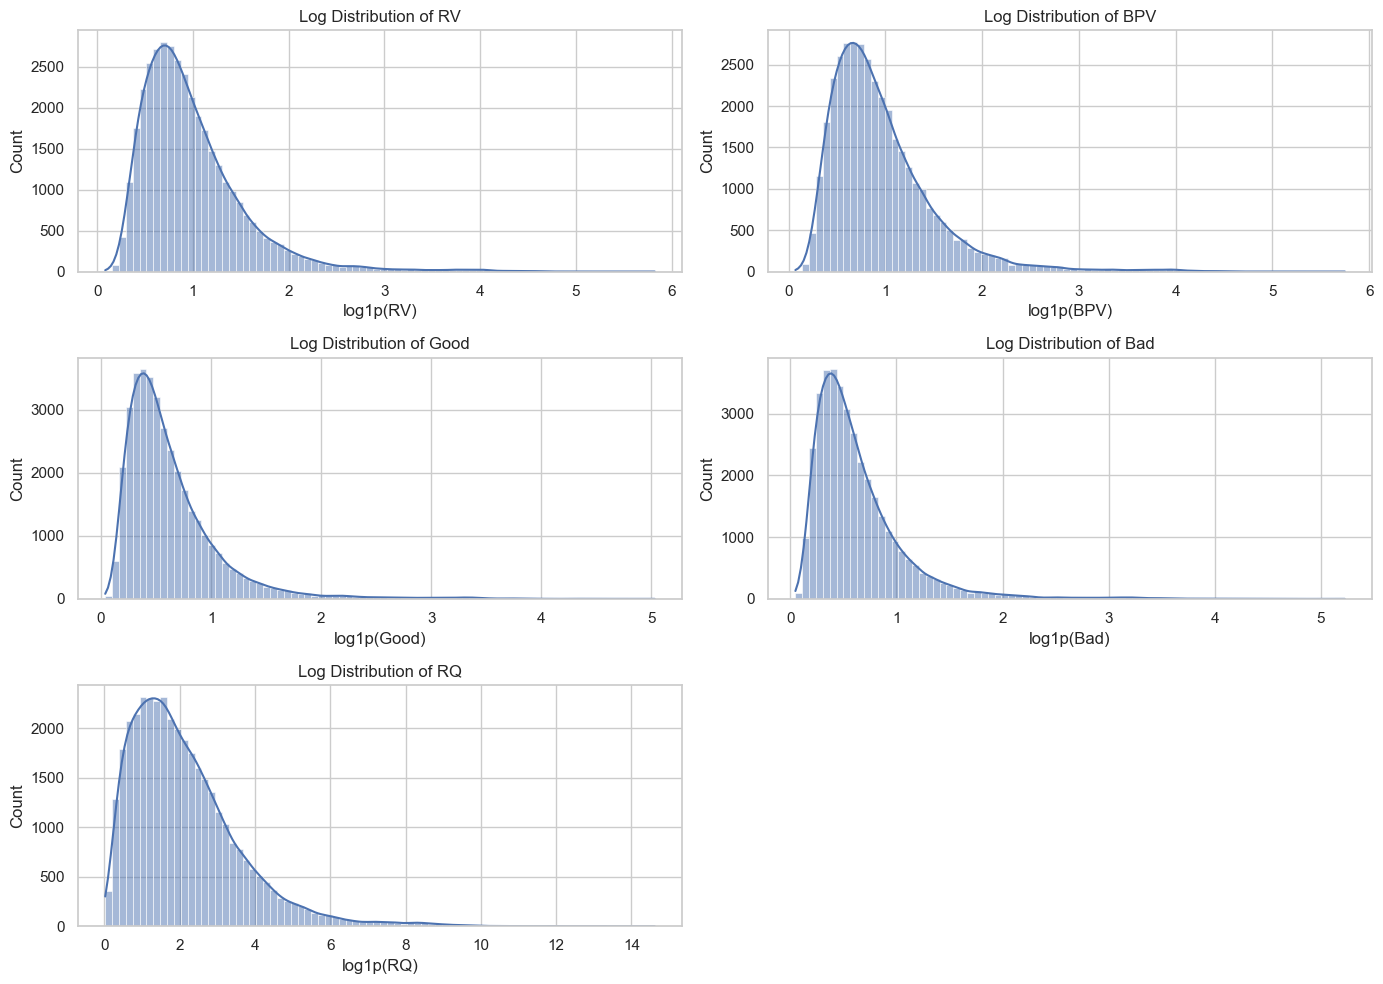

In [17]:
plt.figure(figsize=(14,10))

for i, f in enumerate(features, 1):
    plt.subplot(3,2,i)
    sns.histplot(np.log1p(df_clean[f]), kde=True, bins=80)
    plt.title(f"Log Distribution of {f}")
    plt.xlabel(f"log1p({f})")

plt.tight_layout()
plt.show()

Note: We removed the raw-scale distribution plots because the volatility measures are extremely right-skewed, making the visualizations uninformative. The log-transformed distributions provide a much clearer and more meaningful view for EDA and modeling.

### Boxplots

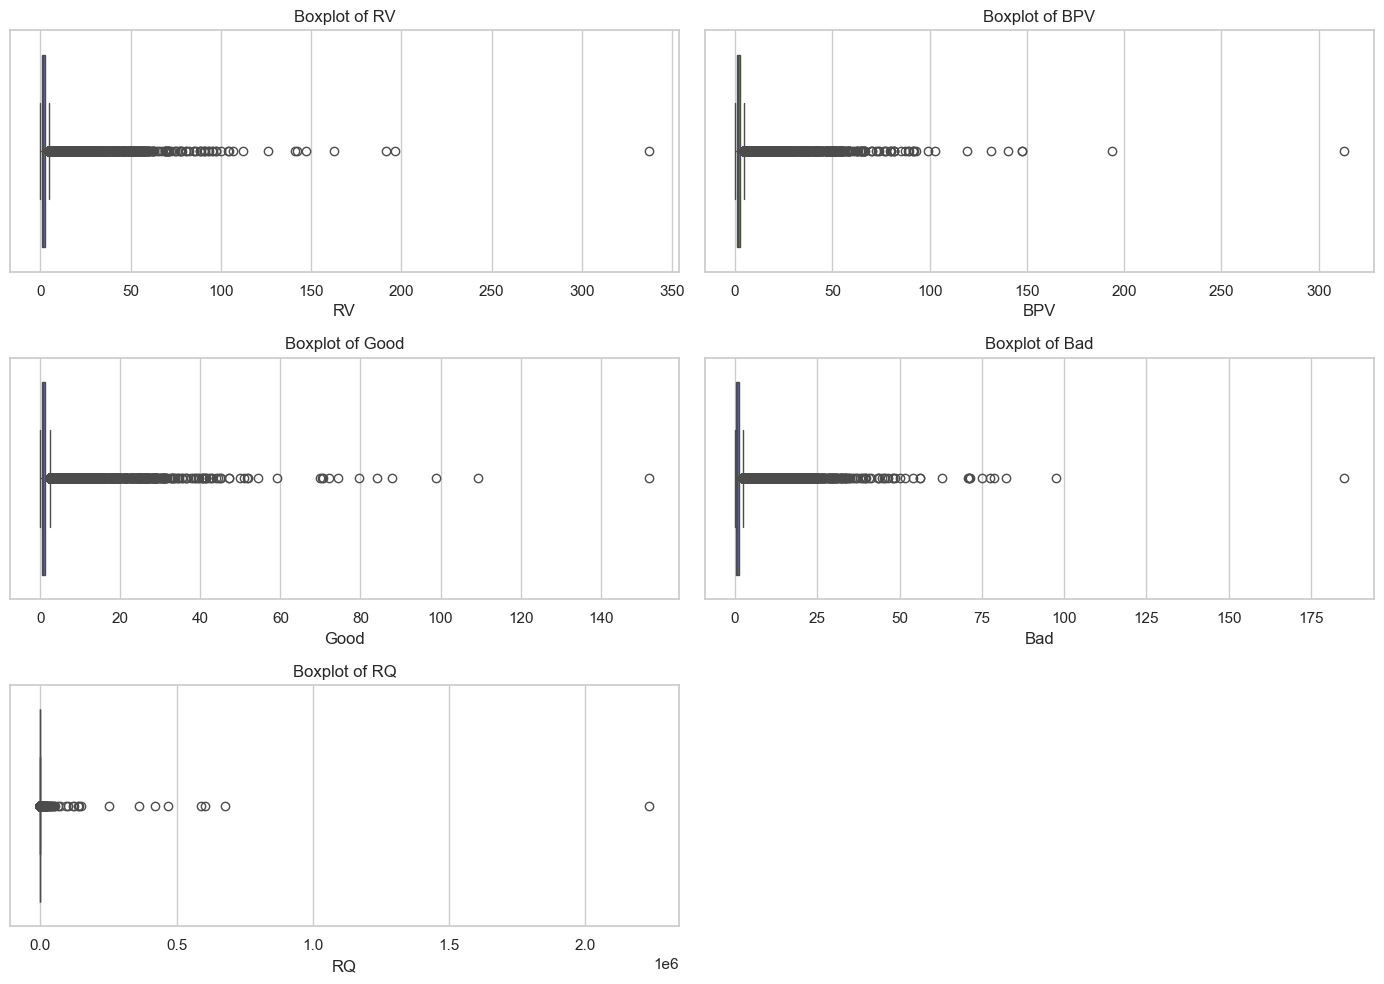

In [18]:
plt.figure(figsize=(14,10))

for i, f in enumerate(features, 1):
    plt.subplot(3,2,i)
    sns.boxplot(x=df_clean[f])
    plt.title(f"Boxplot of {f}")

plt.tight_layout()
plt.show()

The boxplots show a very large number of outliers across all volatility measures.
This is expected because high-frequency volatility metrics exhibit heavy-tailed behavior.
Many “outliers” correspond to real volatility spikes (e.g., COVID-19 or major market events), not errors.

### Time Series Overview

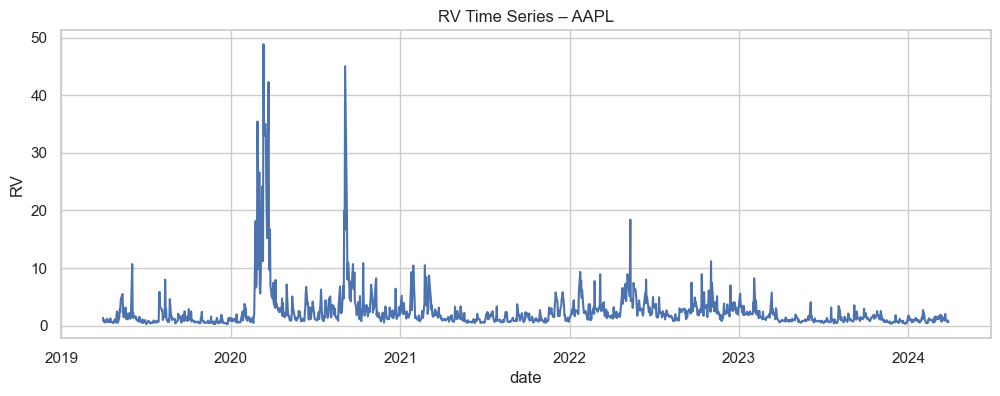

In [19]:
plt.figure(figsize=(12,4))
sns.lineplot(data=df_clean[df_clean["ticker"]=="AAPL"], x="date", y="RV")
plt.title("RV Time Series – AAPL")
plt.show()

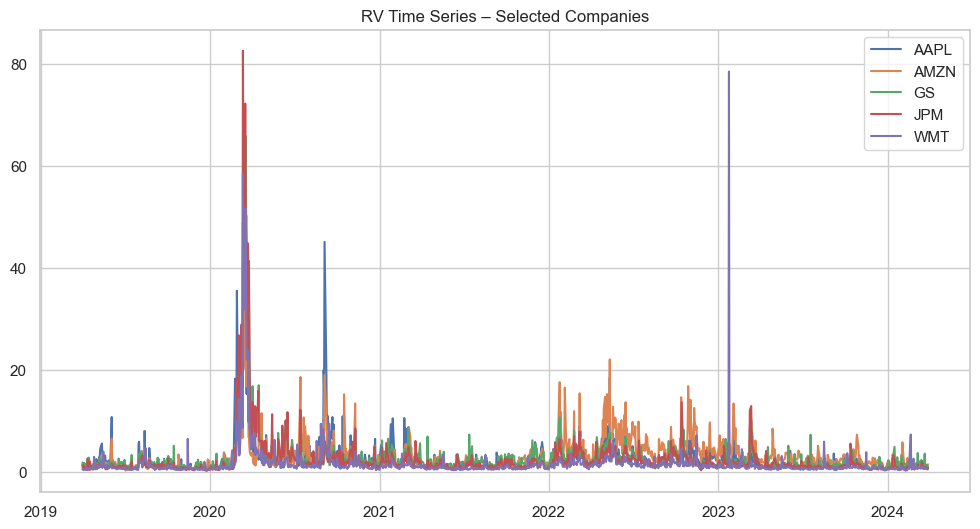

In [20]:
sample_tickers = ["AAPL", "AMZN", "GS", "JPM", "WMT"]

plt.figure(figsize=(12,6))
for t in sample_tickers:
    sub = df_clean[df_clean["ticker"]==t]
    plt.plot(sub["date"], sub["RV"], label=t)

plt.legend()
plt.title("RV Time Series – Selected Companies")
plt.show()

It is not necessary (and not even useful) to plot 30 time-series curves on one figure, because the plot would become visually cluttered and impossible to interpret. Instead, we select a small representative subset of companies—covering different sectors (e.g., tech, retail, finance, industrials)—to illustrate the overall volatility patterns.

Across these selected firms, the time-series show very similar dynamics: large spikes during the COVID-19 crash (2020), elevated volatility during inflation and rate-hike cycles (2021–2022), and a calmer regime in 2023–2024. This similarity is expected because all DJIA constituents are influenced by the same macro-financial shocks. The purpose of the overview is to confirm that the volatility behavior is broadly consistent across the index, before we move to feature engineering and modeling.

### Cross-Sectional Comparison

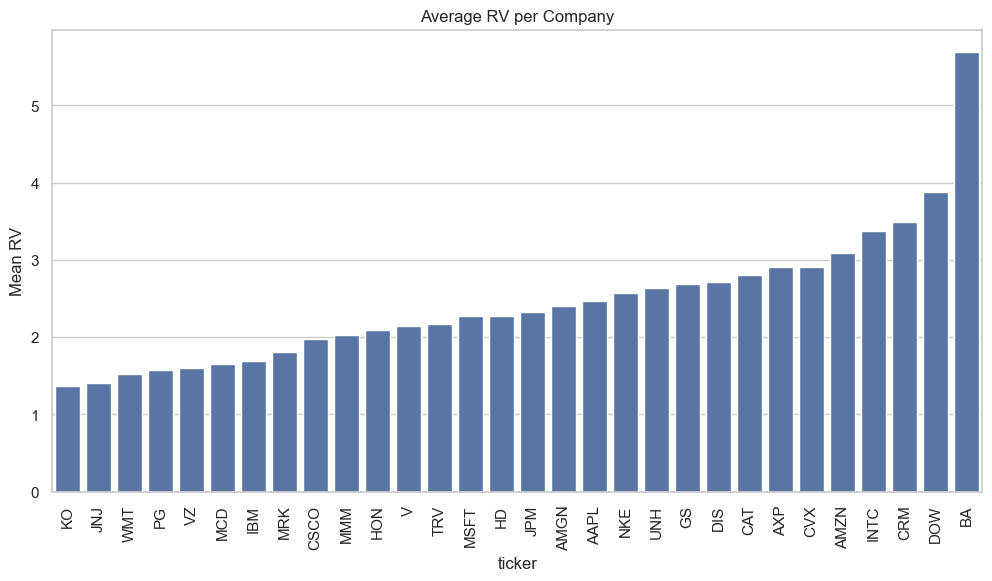

In [21]:
mean_rv = df_clean.groupby("ticker")["RV"].mean().sort_values()

plt.figure(figsize=(12,6))
sns.barplot(x=mean_rv.index, y=mean_rv.values)
plt.xticks(rotation=90)
plt.title("Average RV per Company")
plt.ylabel("Mean RV")
plt.show()

### Correlation Analysis

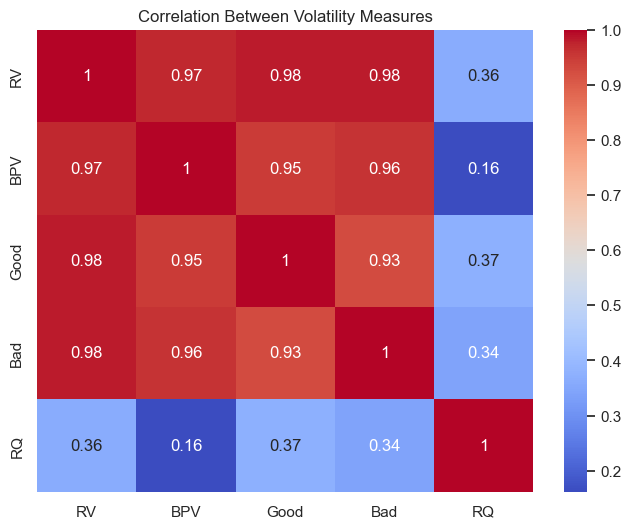

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(df_clean[features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Volatility Measures")
plt.show()

The heatmap shows strong positive correlations among RV, BPV, Good, and Bad, indicating that these volatility measures move closely together and capture similar market dynamics. Realized Quarticity (RQ), however, has much weaker correlations with the other measures, suggesting that it contains different higher-order information related to tail risk and extreme returns. This distinction is important for modeling: RV/BPV/Good/Bad may be partially redundant, while RQ can provide additional independent signals about volatility behavior.

### Jump Analysis

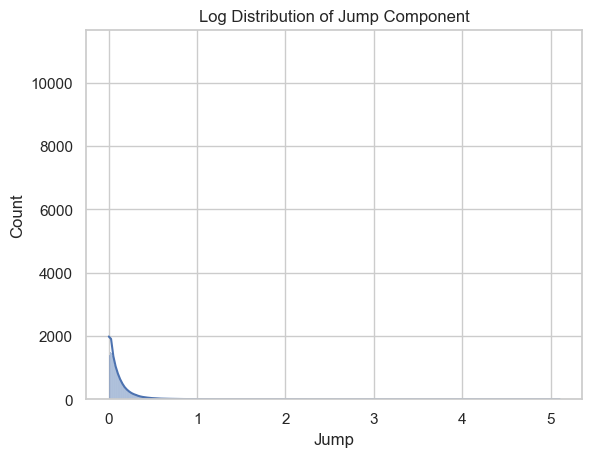

In [25]:
df_clean["Jump"] = df_clean["RV"] - df_clean["BPV"]

sns.histplot(np.log1p(df_clean["Jump"].clip(lower=0)), kde=True)
plt.title("Log Distribution of Jump Component")
plt.show()

The distribution plot shows that jump values are extremely sparse—most days have almost no jump activity, but a few days exhibit large spikes, consistent with the idea that jumps represent rare but impactful market events.

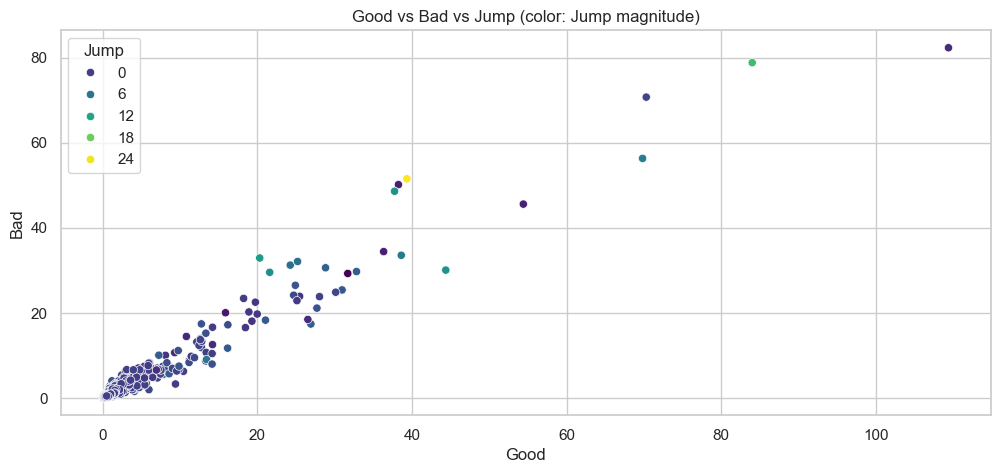

In [26]:
plt.figure(figsize=(12,5))
sns.scatterplot(data=df_clean.sample(5000), x="Good", y="Bad", hue="Jump", palette="viridis")
plt.title("Good vs Bad vs Jump (color: Jump magnitude)")
plt.show()

The scatter plot of Good vs. Bad variance (colored by jump magnitude) highlights that large jumps typically occur on days with elevated volatility, reinforcing the interpretation that jump components capture extreme market movements. Including the jump feature can improve volatility forecasting and is widely used in financial econometrics.